In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import pickle
import zipfile

In [2]:
# Step 1: Unzip the ZIP files
zip_filenames = ['Dengue-4-sequences.zip', 'Ebola-sequences.zip', 'SARS-CoV-2-sequences.zip', 'hepatitis-C-3a-sequences.zip', 'influenza-A-sequences.zip', 'mers-sequences.zip']

for zip_filename in zip_filenames:
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall()

fasta_filenames = [filename[:-4] for filename in zip_filenames]

In [3]:
# Step 2: Apply k-mer encoding
def k_mer_enc(filename: str, k: int):
    with open(filename + '.fasta', 'r') as file:
        seqs = []
        seq = ""
        for line in file.readlines():
            if line.startswith('>'):
                if len(seq) > 0:
                    seqs.append(seq)
                    seq = ""
            else:
                seq += line.strip('\n')
        if len(seq) > 0:
            seqs.append(seq)

        print(f'The file {filename} has {len(seqs)} sequences.')

        encodings = []
        for seq in seqs:
            encoding = []
            code = 0
            for c in seq:
                code *= 4
                if c == 'A':
                    code += 0
                if c == 'C':
                    code += 1
                if c == 'G':
                    code += 2
                if c == 'T':
                    code += 3
                code %= 4 ** k
                encoding.append(code)
            assert len(seq) == len(encoding), 'Error: Unmatched number of characters!'
            encodings.append(encoding)
        assert len(seqs) == len(encodings), 'Error: Unmatched number of sequences!'

        with open(filename + '.pkl', 'wb') as pkfile:
            pickle.dump(encodings, pkfile)

filenames = ['Dengue-4-sequences', 'Ebola-sequences', 'hepatitis-C-3a-sequences',
             'influenza-A-sequences', 'mers-sequences', 'SARS-CoV-2-sequences']
for filename in filenames:
    k_mer_enc(filename, 4)


The file Dengue-4-sequences has 3587 sequences.
The file Ebola-sequences has 4001 sequences.
The file hepatitis-C-3a-sequences has 3331 sequences.
The file influenza-A-sequences has 3669 sequences.
The file mers-sequences has 1633 sequences.
The file SARS-CoV-2-sequences has 4752 sequences.


In [4]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size

        padding = kernel_size // 2

        self.conv = nn.Sequential(
            nn.Conv2d(input_channels + hidden_channels, 4 * hidden_channels, kernel_size, 1, padding),
            nn.GroupNorm(4 * hidden_channels // 32, 4 * hidden_channels)
        )

    def forward(self, input, hidden):
        h_cur, c_cur = hidden
        combined = torch.cat([input, h_cur], dim=1)
        conv_out = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_out, self.hidden_channels, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

In [5]:
class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, num_layers):
        super(ConvLSTM, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_channels = self.input_channels if i == 0 else self.hidden_channels

            cell_list.append(ConvLSTMCell(cur_input_channels, self.hidden_channels, self.kernel_size))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input, hidden=None):
        b, t, c, h, w = input.size()

        if hidden is None:
            hidden = self.init_hidden(input)

        layer_output_list = []
        last_states = []

        seq_len = input.size(1)
        for layer_idx in range(self.num_layers):
            h, c = hidden[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input[:, t, :, :], (h, c))
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            input = layer_output

            layer_output_list.append(layer_output)
            last_states.append((h, c))

        if self.num_layers == 1:
            return layer_output_list[0], last_states[0]
        else:
            return layer_output_list, last_states

    def init_hidden(self, input):
        b, _, _, h, w = input.size()
        hidden = []
        for i in range(self.num_layers):
            hidden.append((torch.zeros(b, self.hidden_channels, h, w).to(input.device),
                           torch.zeros(b, self.hidden_channels, h, w).to(input.device)))
        return hidden

In [6]:
class VirusClassifier(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, num_layers, output_size):
        super(VirusClassifier, self).__init__()

        self.hidden_channels = hidden_channels  # Add this line
        self.conv_lstm = ConvLSTM(input_channels, hidden_channels, kernel_size, num_layers)
        self.fc = nn.Linear(hidden_channels, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, t, c, h, w = x.size()
        print(f"x size before ConvLSTM: {x.size()}")
        x, _ = self.conv_lstm(x.view(b, t, c, h, w))
    
        for i, output in enumerate(x):
            print(f"Output {i} size: {output.size()}")
    
        x = x[-1]
        print(f"x size after ConvLSTM: {x.size()}")
        x = torch.mean(x, dim=[2, 3])
        x = x.view(x.size(0), -1)  # Flatten the tensor
    
        if x.size(1) != self.fc.in_features:
            x = x[:, :self.fc.in_features]  # Make sure the input shape matches the expected shape
    
        x = self.fc(x)
        x = self.sigmoid(x)
        x = x.squeeze(1)  # Add this line to remove the extra dimension
        return x

In [7]:
# Step 4: Model training and evaluation
class VirusDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        encoding = self.encodings[idx]
        # Reshape the encoding to have dimensions (time_steps, channels, height, width)
        encoding = encoding.reshape(encoding.shape[0], 1, 1, 1)
        # Convert the encoding to a FloatTensor
        encoding = torch.FloatTensor(encoding)
        return encoding, self.labels[idx]

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, targets in dataloader:
        # Move tensors to the correct device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    average_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions

    return average_loss, accuracy


In [8]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device).float()  # Convert targets to Float data type

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total += targets.size(0)
        correct += ((outputs > 0.5) == targets).sum().item()

    return running_loss / (batch_idx + 1), correct / total

In [9]:
def evaluate(model, dataloader):
    model.eval()
    predictions = []
    truths = []
    probs = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())
            truths.extend(labels.cpu().numpy())
            probs.extend(outputs.cpu().numpy())

    return predictions, truths, probs


In [10]:
def plot_roc_curve(y_true, y_pred_prob, num_classes):
    fpr = dict()
    tpr = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_pred_prob[:, i], pos_label=i)

    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

In [11]:
# Parameters
input_channels = 1
hidden_channels = 64
kernel_size = 3
num_layers = 2
output_size = 1

model = VirusClassifier(input_channels, hidden_channels, kernel_size, num_layers, output_size)

In [13]:
# Load data
encodings = []
labels = []
for label, fasta_filename in enumerate(fasta_filenames):
    with open(fasta_filename + '.pkl', 'rb') as pkfile:
        file_encodings = pickle.load(pkfile)
        encodings.extend([np.array(enc) for enc in file_encodings])  # Convert nested lists to NumPy arrays
        labels.extend([label] * len(file_encodings))

encodings = np.array(encodings, dtype=object)
labels = np.array(labels)

# Find the maximum sequence length
max_seq_len = max([enc.shape[0] for enc in encodings])

# Pad encodings with zeros to create tensors
encodings_padded = []
for enc in encodings:
    pad_rows = max_seq_len - enc.shape[0]
    enc_padded = np.pad(enc, (0, pad_rows), mode='constant', constant_values=0)
    encodings_padded.append(enc_padded)

encodings = np.stack(encodings_padded)

In [14]:
def normalize_encodings(encodings):
    mean = np.mean(encodings)
    std = np.std(encodings)
    return (encodings - mean) / std

encodings = normalize_encodings(encodings)

In [16]:
# Training Parameters
num_epochs = 20
learning_rate = 0.00001
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the correct device
model.to(device)

VirusClassifier(
  (conv_lstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Sequential(
          (0): Conv2d(65, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(8, 256, eps=1e-05, affine=True)
        )
      )
      (1): ConvLSTMCell(
        (conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(8, 256, eps=1e-05, affine=True)
        )
      )
    )
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [17]:
# Step 1: Split the data into train, and test sets
X_train, X_test, y_train, y_test = train_test_split(encodings, labels, test_size=0.2, random_state=42)

train_dataset = VirusDataset(X_train, y_train)
test_dataset = VirusDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Step 2: Create an EarlyStopping class
#class EarlyStopping:
#    def __init__(self, patience=8, min_delta=0.001):
#        self.patience = patience
#        self.min_delta = min_delta
#        self.counter = 0
#        self.best_loss = None
#        self.stop = False
#
#    def __call__(self, val_loss):
#        if self.best_loss is None:
#            self.best_loss = val_loss
#        elif self.best_loss - val_loss > self.min_delta:
#            self.best_loss = val_loss
#            self.counter = 0
#        else:
#            self.counter += 1
#            print(f"Early stopping counter: {self.counter} out of {self.patience}")
#            if self.counter >= self.patience:
#                self.stop = True

In [18]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Train the model
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_dataloader, criterion, optimizer)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}")

x size before ConvLSTM: torch.Size([32, 30484, 1, 1, 1])
Output 0 size: torch.Size([32, 30484, 64, 1, 1])
Output 1 size: torch.Size([32, 30484, 64, 1, 1])
x size after ConvLSTM: torch.Size([32, 30484, 64, 1, 1])
x size before ConvLSTM: torch.Size([32, 30484, 1, 1, 1])
Output 0 size: torch.Size([32, 30484, 64, 1, 1])
Output 1 size: torch.Size([32, 30484, 64, 1, 1])
x size after ConvLSTM: torch.Size([32, 30484, 64, 1, 1])
x size before ConvLSTM: torch.Size([32, 30484, 1, 1, 1])
Output 0 size: torch.Size([32, 30484, 64, 1, 1])
Output 1 size: torch.Size([32, 30484, 64, 1, 1])
x size after ConvLSTM: torch.Size([32, 30484, 64, 1, 1])


In [69]:
torch.save(model.state_dict(), "virus_classification_model_0.00001.pt")

In [76]:
# Evaluate model
y_pred, y_true, y_probs = evaluate(model, test_dataloader)

# Metrics
#test_loss = criterion(torch.tensor(y_pred), torch.tensor(y_true)).item()
test_acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
specificity = recall_score(y_true, y_pred, average='macro', pos_label=0)
f_score = f1_score(y_true, y_pred, average='macro')
#print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F-score: {f_score:.4f}")

Test Acc: 0.2198
Precision: 0.0366
Recall: 0.1667
Specificity: 0.1667
F-score: 0.0601


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1379: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [77]:
# AUC scores
y_pred_prob = torch.softmax(torch.tensor(y_probs), dim=1).numpy()
for i in range(output_size):
    auc = roc_auc_score(np.array(y_true) == i, y_pred_prob[:, i])
    print(f"AUC score (Class {i} vs. Other Classes): {auc:.4f}")

AUC score (Class 0 vs. Other Classes): 0.4996
AUC score (Class 1 vs. Other Classes): 0.5000
AUC score (Class 2 vs. Other Classes): 0.5000
AUC score (Class 3 vs. Other Classes): 0.5000
AUC score (Class 4 vs. Other Classes): 0.5000
AUC score (Class 5 vs. Other Classes): 0.5000


/tmp/ipykernel_401/2558289316.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /home/mist/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  y_pred_prob = torch.softmax(torch.tensor(y_probs), dim=1).numpy()


In [78]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[  0   0 700   0   0   0]
 [  0   0 799   0   0   0]
 [  0   0 922   0   0   0]
 [  0   0 681   0   0   0]
 [  0   0 757   0   0   0]
 [  0   0 336   0   0   0]]


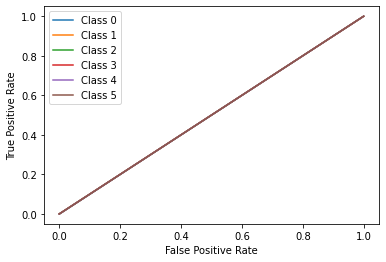

In [79]:
# ROC Curve
plot_roc_curve(y_true, y_pred_prob, output_size)

In [81]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.bfsu.edu.cn/pypi/web/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 1.8 MB/s eta 0:00:0000:0100:01


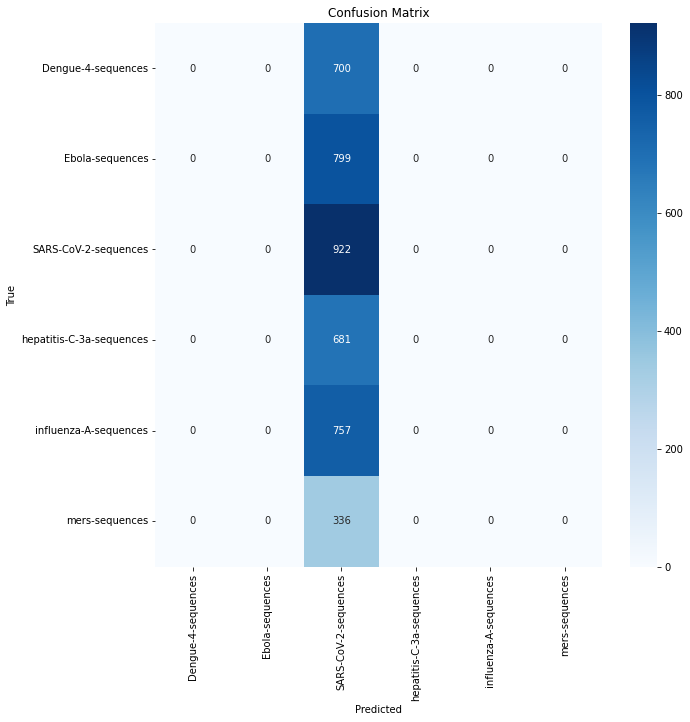

In [82]:
import seaborn as sns

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(cm, fasta_filenames)

In [83]:
for i in range(output_size):
    auc = roc_auc_score(np.array(y_true) == i, y_pred_prob[:, i])
    print(f"AUC score (Class {i} vs. Other Classes): {auc:.4f}")

AUC score (Class 0 vs. Other Classes): 0.4996
AUC score (Class 1 vs. Other Classes): 0.5000
AUC score (Class 2 vs. Other Classes): 0.5000
AUC score (Class 3 vs. Other Classes): 0.5000
AUC score (Class 4 vs. Other Classes): 0.5000
AUC score (Class 5 vs. Other Classes): 0.5000


In [12]:
import torch
torch.cuda.empty_cache()